In [2]:
import sys 
import os
sys.path.append(os.path.abspath("..")) # so we can find didson.py, multibeam.py

from glob import glob           # file manipulation
import numpy as np
from skimage.io import imread, imsave  # image processing
from scipy.stats import cauchy, norm #chi2, erlang, expon, genexpon, ncx2, poisson, powerlaw, rayleigh

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
image_list = sorted(glob('../data/dataset-1/*raw.png'))
print len(image_list)

import cv2
from sonar import Sonar
from didson import Didson

didson = Didson();
didson.load_config('../data/DIDSON/didson.json')

10


image: 1
0.0 0.525490196078
(512, 96)


(-0.5, 511.5, 95.5, -0.5)

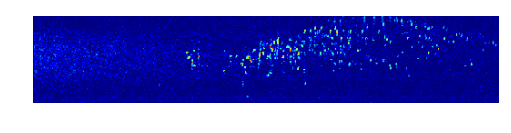

In [4]:
idx = np.random.randint(0,len(image_list))

print 'image:',idx
# img = imread(image_list[idx], as_grey=True)
ping = cv2.imread(image_list[idx],cv2.CV_LOAD_IMAGE_GRAYSCALE)
img = didson.deconvolve(ping)
# img = ping
img = img.astype(np.float64)/255.0
print np.amin(img), np.amax(img)
print img.shape
plt.imshow(ping.transpose())
plt.axis('off')

In [5]:
def unary_cost(x,y):
    """Compute the total cost for unary potentials"""
    cost = 0
    r = np.linspace(2.25,11.75,512)
    for b in range(0,96):
        # measurement
        y = ping[:,b]
        e = np.sum(y) 
        
        # prediction
        yp = cauchy.pdf(r, loc=x[b], scale=0.02) 
        yp/=np.sum(yp)
        
        cost+=np.sum(np.square(y-yp))
    return cost

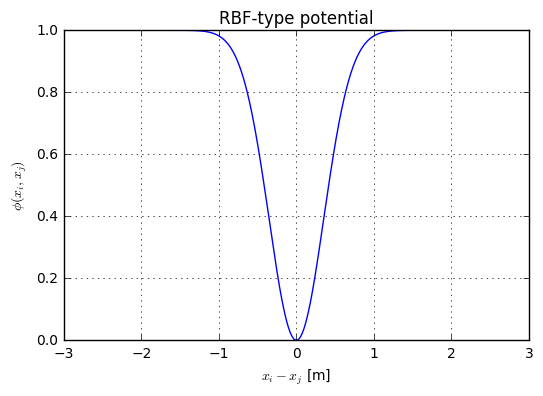

In [14]:
def binary_cost(x,w=1.0):
    """Compute the total cost for binary potentials"""
    d = w*np.diff(x)
    c = 1-np.exp(-np.square(d/w))

    return(np.sum(c))
#     return (np.sum(np.abs(d)))

# validate cost function
xt = np.linspace(-2.25,2.25,512)
bc = 1- np.exp(-np.square(xt/.5))
# xt = np.linspace(-9.5,9.5,1024)
# bc = np.abs(20*xt)
plt.plot(xt,bc)
plt.ylabel('$\phi(x_i,x_j)$')
plt.xlabel('$x_i-x_j$ [m]')
plt.grid()
plt.title('RBF-type potential')
plt.savefig('rbf-potential.png')

In [6]:
def initrandom():
    x = 2.25+9.5*np.random.rand(96)
    return(x)

def initialize(y):
    """Compute the initial label assignment."""
    x = np.argmax(y,0)
    r = np.linspace(2.25,11.75,512)
    return(r[x])
    
def perturb(x, sigma=0.2):
    """Randomly perturb a solution vector."""
    xp = np.copy(x)
    # randomly select index
    idx = np.random.randint(0,len(xp))
#     perturb selected index by random amount
    xp[idx] += sigma*np.random.randn()

    return(xp)


def predict(x):
    """Predict the image, based on the current labels"""
    r = np.linspace(2.25,11.75,512)
    yp = np.zeros((512,96))
    for b in range(0,96):
        yp[:,b] = cauchy.pdf(r, loc=x[b], scale=0.05)
        yp[:,b]/=np.amax(yp)

    return(yp)
    
def solve(y,wu,wb,N):
    """Compute range measurements through simulated annealing.
    
    Arguments:
    y -- the input image
    wu -- unary cost weight
    wb -- binary cost weight
    N -- Number of iterations
    
    Note: the cost weights should be initialized so that they're comparable.
    There's an upper bound of B-1 on the total binary cost.
    """
    x = initialize(y) # initial solution
#     x = initrandom()
#     x = 8.0*np.ones(96)
    cost = 1e20       # initial cost
    t0 = 1            # initial temperature
    cl = np.zeros(N)
    
    for i in range(0,N):
        # compute temperature
        t = t0/(np.log(max(i,1)))
        
        # candidate solution
        xc = perturb(x,0.02)
        ci = wu*unary_cost(xc, y) + wb*binary_cost(xc, 1e-1)
                
        # check for improvement
        delta = ci-cost # new - old
        if (delta < 0):
            #  lower cost, keep it
            x = np.copy(xc)
            cost = ci
        else:
            # accept higher cost with decreasing likelihood
            s = np.exp(-delta/t)
#             print 's:    ',s
#             print 'delta:',delta

            if np.random.rand() < s :
#                 print 'a'
                x = np.copy(xc)
                cost = ci
                
#         if(0==i%(N/10)):
#             print 'temp:   ', t
#             print 'unary:  ', wu*np.sum(unary_cost(x,y))
#             print 'binary: ', wb*np.sum(binary_cost(x))
#             print 'cost:   ', cost
#             print ''
            
        cl[i] = cost
    
    print 'unary:  ', wu*np.sum(unary_cost(x,y))
    print 'binary: ', wb*np.sum(binary_cost(x))
    print 'cost:   ', cost
    print ''
    return(x,cl)
        
    
    

2040


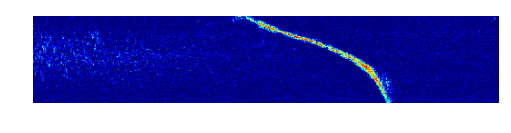

/home/pvt/anaconda2/envs/multibeam/lib/python2.7/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in double_scalars


unary:   807.411943009
binary:  2362.98068347
cost:    3170.39262648



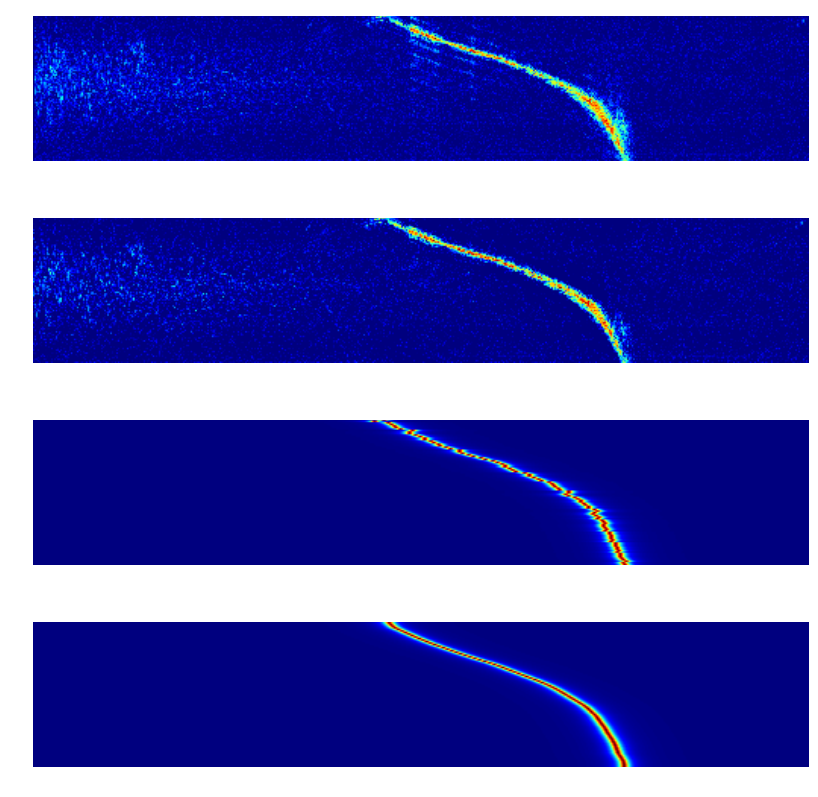

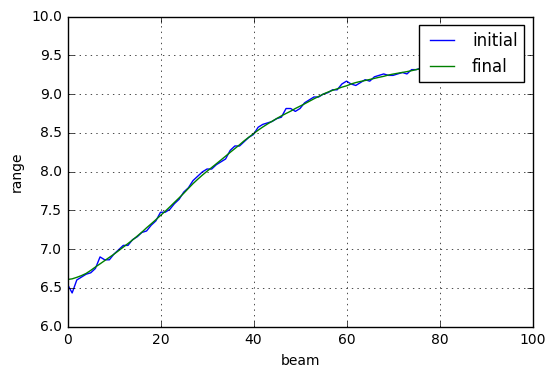

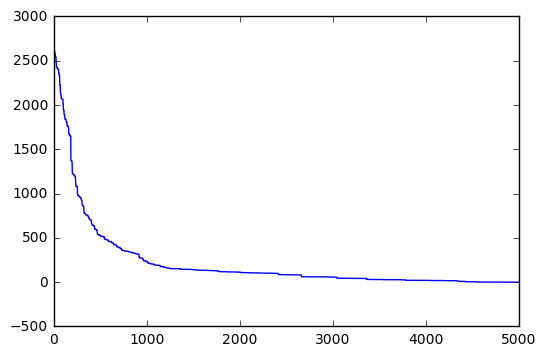

In [7]:
image_list = sorted(glob('/home/pvt/data/pings/raw/*.png'))

idx = np.random.randint(0,len(image_list))
idx = 2040
print idx
ping = cv2.imread(image_list[idx],cv2.CV_LOAD_IMAGE_GRAYSCALE)
ping = ping.astype(np.float64)/255.0
img = didson.deconvolve(ping)
# img = img.astype(np.float64)/255.0
plt.figure()
plt.imshow(img.transpose())
plt.axis('off')
plt.show()

y = img

plt.figure(figsize=(10,10))
plt.subplot(4,1,1)
plt.imshow(ping.transpose())
plt.axis('off')

plt.subplot(4,1,2)
plt.imshow(y.transpose())
plt.axis('off')

(x,c) = solve(y, 1.0e1, 2.0e4, 5000)

plt.subplot(4,1,3)
plt.imshow(predict(initialize(y)).transpose())
plt.axis('off')

plt.subplot(4,1,4)
plt.imshow(predict(x).transpose())
plt.axis('off')
plt.show()

plt.figure()
plt.plot(initialize(y))
plt.plot(x)
plt.grid()
plt.xlabel('beam')
plt.ylabel('range')
plt.legend(['initial','final'])

plt.figure()
plt.plot(c-c[-1])
# plt.ylim([0,c[0]])


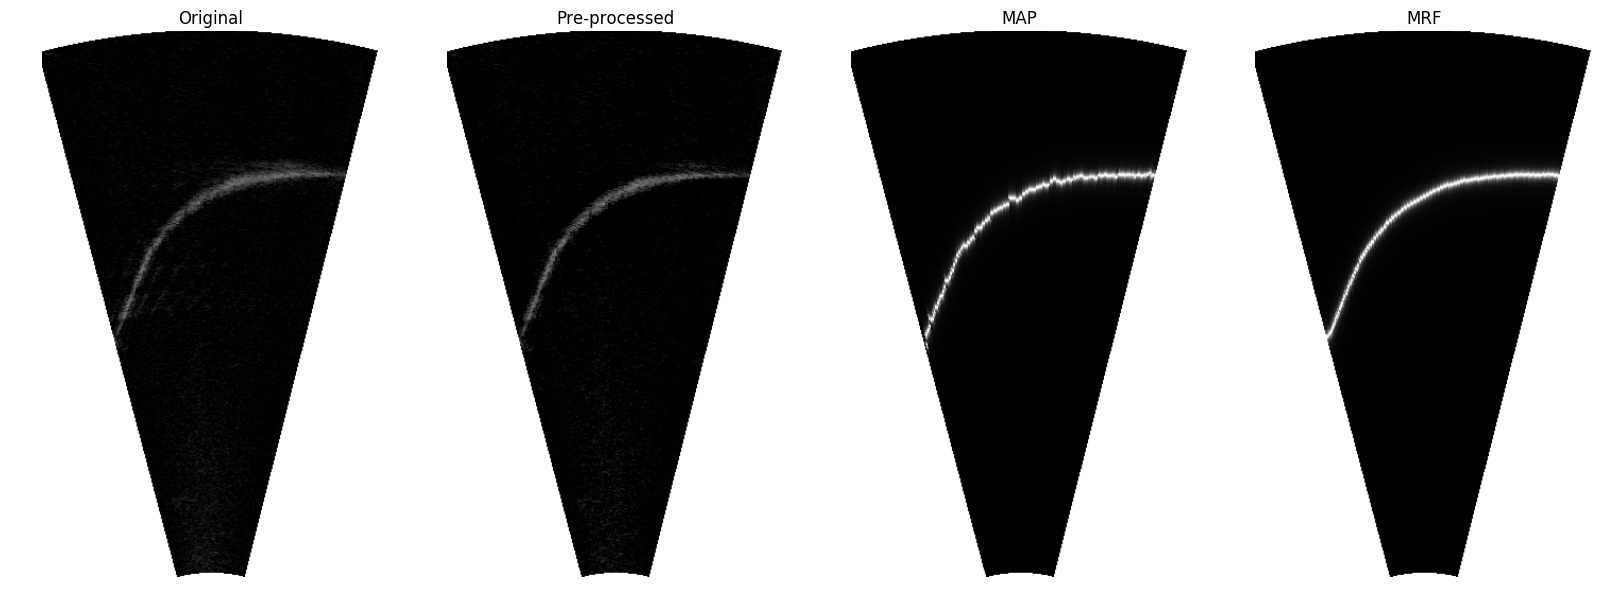

In [9]:
# fname = image_list[idx][:-4];
import scipy.misc

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
yc = np.flipud(didson.to_cart(ping,1.0))
scipy.misc.imsave('smrf_'+str(idx)+'_original.png',yc)
plt.imshow(yc,cmap='gray')
plt.axis('off')
plt.title('Original')


plt.subplot(1,4,2)
yec=np.flipud(didson.to_cart(y,1.0))
scipy.misc.imsave('smrf_'+str(idx)+'_deconv.png',yec)
plt.imshow(yec,cmap='gray')
plt.axis('off') 
plt.title('Pre-processed')


# initial (max)
plt.subplot(1,4,3)
yic = np.flipud(didson.to_cart(predict(initialize(y)),1.0))
scipy.misc.imsave('smrf_'+str(idx)+'_init.png',yic)
plt.imshow(yic,cmap='gray')
plt.axis('off')
plt.title('MAP')


# final
plt.subplot(1,4,4)
ypc = np.flipud(didson.to_cart(predict(x),1.0));
scipy.misc.imsave('smrf_'+str(idx)+'_smrf.png',ypc)
plt.imshow(ypc,cmap='gray')
plt.axis('off')
plt.title('MRF')

plt.savefig('sparse_mrf_'+str(idx)+'.png')

plt.show()


In [229]:
image_list = sorted(glob('/home/pvt/data/pings/raw/*.png'))

for idx in range(1000,10000,10):

    print idx

    ping = cv2.imread(image_list[idx],cv2.CV_LOAD_IMAGE_GRAYSCALE)
    ping = ping.astype(np.float64)/255.0
    img = didson.deconvolve(ping)

    y = img

    (x,c) = solve(y, 1.0e1, 2.0e4, 5000)


    yc = np.flipud(didson.to_cart(ping,1.0))
    scipy.misc.imsave('smrf_'+str(idx)+'_original.png',yc)


    yec=np.flipud(didson.to_cart(y,1.0))
    scipy.misc.imsave('smrf_'+str(idx)+'_deconv.png',yec)


    # initial (max)

    yic = np.flipud(didson.to_cart(predict(initialize(y)),1.0))
    scipy.misc.imsave('smrf_'+str(idx)+'_init.png',yic)


    ypc = np.flipud(didson.to_cart(predict(x),1.0));
    scipy.misc.imsave('smrf_'+str(idx)+'_smrf.png',ypc)


1000


/home/pvt/anaconda2/envs/multibeam/lib/python2.7/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in double_scalars


unary:   927.291842689
binary:  591346.877057
cost:    592274.1689

1010
unary:   1055.23453711
binary:  539197.072023
cost:    540252.30656

1020
unary:   677.416533759
binary:  605819.806494
cost:    606497.223028

1030
unary:   543.57217584
binary:  838701.069917
cost:    839244.642092

1040
unary:   607.468848735
binary:  531018.563158
cost:    531626.032007

1050
unary:   982.659501211
binary:  490304.752016
cost:    491287.411517

1060
unary:   965.082089767
binary:  498655.13023
cost:    499620.212319

1070
unary:   964.458250289
binary:  408679.079039
cost:    409643.53729

1080
unary:   1012.03862315
binary:  571594.087251
cost:    572606.125874

1090
unary:   1064.47082366
binary:  488720.448945
cost:    489784.919769

1100
unary:   1020.58425862
binary:  494037.156408
cost:    495057.740667

1110
unary:   1150.59287508
binary:  541350.011769
cost:    542500.604644

1120
unary:   1018.41046129
binary:  561316.686753
cost:    562335.097214

1130
unary:   852.601340721
binary: 

KeyboardInterrupt: 

In [ ]:
# %%timeit

"""
Tunable parameters:
- Cauchy scale
- Transition cost & cooling;.
- relative weight (u0/u1)
- 1st-order void-label cost

To Do:
- better edge handling on roll 
- handle "void" labels on transition cost (should get replaced by fixed cost!)
- try other transition weights (not just normal) - e.g. triangular, parabolic, square window
- speed up computation (need <0.1/loop)
- track empirical pdf for transition
"""
# c_scale = 0.33
c_scale = 1
void_cost = .5 # transition cost
w1 = 1

# get a prior on the labels
midx = np.argmax(img, axis=0) # return max location per row
midx.shape = (1,96)

# pre-allocate vector used to evaluate Cauchy functions
x = np.arange(0.0,512.0, 1.0)
x.shape = (512,1)
x = np.tile(x,(1,96))
    
# compute 0-order label cost map 
u0 = np.zeros_like(x)
    
# one for each range assignment (this is taking most of the time (>2s))
for i in range(0,512):
    u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)
    
# 'void' label
u0v = np.sum(np.square(img),axis=0) 
u0 = np.vstack((u0v,u0))
# u0/=u0.max() # range 0-1

s = 250

i = 0
while True:
    i = i+1
    
    a = np.tile(midx,(512,1))
    l = np.roll(a,1,axis=1)
    l[:,0]=l[:,1]
#     ll = np.roll(l,1, axis=1)
#     ll[:,0]=ll[:,1]
    r = np.roll(a,-1,axis=1)
    r[:,-1] = r[:,-2]
#     rr = np.roll(r,-1, axis=1)
#     rr[:,-1] = rr[:,-2]  

    s = 0.5*s;
    u1 = 2 - 2.5*s*norm.pdf((l-x),loc=0, scale=s ) - 2.5*s*norm.pdf((r-x),loc=0, scale=s )
#     u1 = 4 - 2.5*s*norm.pdf((l-x),loc=0, scale=s ) - 2.5*s*norm.pdf((r-x),loc=0, scale=s ) - 2.5*s*norm.pdf((ll-x),loc=0, scale=s ) - 2.5*s*norm.pdf((rr-x),loc=0, scale=s )
#     u1 = 4 - 2.5*s*np.absolute(l-x) - 2.5*s*np.absolute(r-x) - 2.5*s*np.absolute(ll-x) - 2.5*s*np.absolute(rr-x)
    u1 = np.vstack((void_cost*np.ones_like(u0v),u1))
#     u1/=u1.max()
    
    print 'u0:',np.amin(u0),'-',np.amax(u0)
    print 'u1:',np.amin(u1),'-',np.amax(u1)
    print 's:',s
#     cost = u0/np.amax(u0) + u1/np.amax(u1)
    cost = u0 + u1
    
    midx_new = np.argmin(cost, axis=0)
    changes = np.sum((midx-midx_new)!=0)
    midx = midx_new
    
    plt.figure(figsize=(10,4))
#     plt.imshow((cost).transpose())
    plt.subplot(1,2,1)
    plt.imshow(u0.transpose())
    plt.subplot(1,2,2)
    plt.imshow(u1.transpose())
    
    if s<5:
        break
    
    if changes<=0:
        break
        
    if i>10:
        break

print 'changes:', changes
        
print 'iterations:',i
plt.figure(figsize=(10,4))
plt.imshow(cost.transpose())
        
simg = cauchy.pdf(x,loc=midx, scale=c_scale)
plt.figure(figsize=(10,4))
plt.imshow(simg.transpose())

plt.figure(figsize=(10,4))
plt.imshow(ping.transpose())
plt.title('Original') 

print midx
print np.diff(midx)

In [ ]:
# %%timeit

c_scale = 2.0

# empty beams will square-integrate to < 0.1
# beams with returns will integrate to > 0.2
# plt.plot(np.sum(np.square(img),axis=0))

# for i in range(0, 512):
#     u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)

i=range(0,512)
u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)

    
a = cauchy.pdf(x, loc = x, scale =c_scale)
# print a.shape

plt.figure()
plt.imshow(u0.transpose())
plt.figure()
plt.imshow(a.transpose())

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img.transpose())

x = np.arange(0.0,512.0, 1.0)
x.shape = (512,1)
x = np.tile(x,(1,96))
plt.figure(figsize=(10,10))
plt.imshow(x.transpose())

for i in range(0, 512):
    u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)

plt.figure(figsize=(10,10))
plt.imshow(u0.transpose())
    
# midx = np.argmax(img, axis=0) # return max location per row
# midx.shape = (1,96)
# print x.shape
# xv = x
# xv.shape =(512,96,1)
# xv = np.tile(x,(1,1,512))
# print xv.shape
# a = cauchy.pdf(xv, loc=x, scale = c_scale)
    u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)
# print a.shape

In [ ]:
# %%timeit
c_scale = 0.33
x = np.arange(0.0,512.0, 1.0)
x.shape = (512,1)
x = np.tile(x,(1,96))
xl = [x] * 512
ml = np.split(x, 512,axis=0)
# print len(ml)
# print ml
print ml[1]
print len(ml)
print x

# u0.shape
# u0 = np.sum(np.square(img - cauchy.pdf(xv, loc=x, scale = c_scale)),axis=0)
# print u0.shape
# plt.imshow(u0[:,:,100].transpose())

In [ ]:
%%timeit
# print len(xl), len(ml)
# print xl[100]
# print ml[100]

# print type(xl)
# print type(xl[0])
# print type(ml)
# print type(ml[0])
# cl = np.asarray(ml)
# print type(cl)

# this works...
# u0 = cauchy.pdf(xl[100], loc=ml[100], scale = c_scale) 
# plt.imshow(u0.transpose())
# ...but this doesn't
# u0 = cauchy.pdf(xl[100:200], loc=ml[100:200], scale = c_scale) 
# plt.imshow(u0[50].transpose())
# ...and neither does this

# plt.imshow(u0[100].transpose())
# print len(u0)
# print u0[0].shape

# BEGIN
u0 = cauchy.pdf(xl, loc=ml, scale = c_scale) 
il = [img]*512
v0 = np.square(u0-il)
v0s = np.sum(v0,axis=1)
v0i = np.array(v0s)
# END

# print len(v0)
# print v0[0].shape

# print len(v0s)
# print v0s[0].shape

# print v0i.shape
# plt.figure()
# plt.imshow(v0i.transpose())
# v = np.array(v0)
# print v.shape
# plt.figure(figsize=(10,10))
# j = 70
# plt.imshow(u0[j].transpose())
# print np.amin(u0[j]), np.amax(u0[j])


u0 = np.zeros_like(x)
    
# one for each range assignment
# this is taking most of the time (>2s)
# for i in range(0,512):
#     u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)
    
# plt.figure()
# plt.imshow(u0.transpose())